# 0.0. Imports 

In [1]:
import pandas                      as pd
import numpy                       as np
import seaborn                     as sns
import inflection
import math
import datetime


from sklearn.ensemble              import RandomForestRegressor
from sklearn.linear_model          import LinearRegression, Lasso
from sklearn.preprocessing         import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics               import mean_absolute_error, mean_squared_error
from scipy.stats                   import chi2_contingency
from scipy                         import stats  as ss
from matplotlib                    import pyplot as plt
from IPython.display               import Image
from matplotlib                    import gridspec
from IPython.core.display          import HTML
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## 0.1. Helper Functions

In [21]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))
    
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt( mean_squared_error(y, yhat))
    
    return pd.DataFrame ( {
        'Model name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])


def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency (cm )[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1 )))
   


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [35, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [22]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [23]:
df_sales_raw = pd.read_csv( 'dataset/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'dataset/store.csv', low_memory=False )

# merge

df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on= 'Store' )

# 1.0 DESCRIBE DATA - Passo 01

In [24]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [25]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
       'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore ( x )

cols_new = list( map( snakecase, cols_old ) )

#rename 
df1.columns = cols_new

## 1.2. Data Dimension

In [26]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of rows: {}'.format( df1.shape[1] ) )

Number of rows: 1017209
Number of rows: 18


## 1.3. Data types

In [27]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Number of NA 

In [28]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [29]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.5. Fillout NA

In [30]:
#promo_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )


#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )


#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )


#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map' ]].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

In [31]:
df1.sample(5).T

,38640,572754,718296,887556,659074
store,731,430,1022,802,895
day_of_week,6,1,4,6,1
date,2015-06-27 00:00:00,2014-02-03 00:00:00,2013-09-26 00:00:00,2013-04-27 00:00:00,2013-11-18 00:00:00
sales,6316,11058,6386,7482,12586
customers,714,822,740,571,1113
open,1,1,1,1,1
promo,0,1,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,a,a


In [32]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change columns Data types

In [33]:
# change competition date
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )

# change promo date
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )

In [34]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive statistics

In [35]:
# split numerical and categorical features
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
dat_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )
print( 'Num of Categorical: {}'.format( cat_attributes.shape[1] ) )
print( 'Num of Date: {}'.format( dat_attributes.shape[1] ) )

Num of Numerical: 10
Num of Categorical: 9
Num of Date: 1


### 1.7.1. Central Tendency and Dispersion

In [36]:
# measure of Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( median ) ).T

# dispersion
d1 = pd.DataFrame( num_attributes.apply( std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'kurtosis', 'skew']

m

,attributes,min,max,range,mean,median,standard_deviation,kurtosis,skew
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-0.000955
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,0.001593
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,0.641460
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,1.598650
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,-1.758045
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,0.487838
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,1.677842
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,147.789712,10.242344
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-1.999999,-0.002255
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.625796,1.904152


### 1.7.2. Categorical Attributes

In [37]:
c = pd.DataFrame( cat_attributes.apply( lambda x: x.unique().shape[0], axis=0 ).reset_index() )
c.columns = ['Columns Names', 'Number of Levels']
c

,Columns Names,Number of Levels
0,state_holiday,4
1,store_type,4
2,assortment,3
3,competition_open_since_month,12
4,competition_open_since_year,23
5,promo2_since_week,52
6,promo2_since_year,7
7,promo_interval,4
8,month_map,12


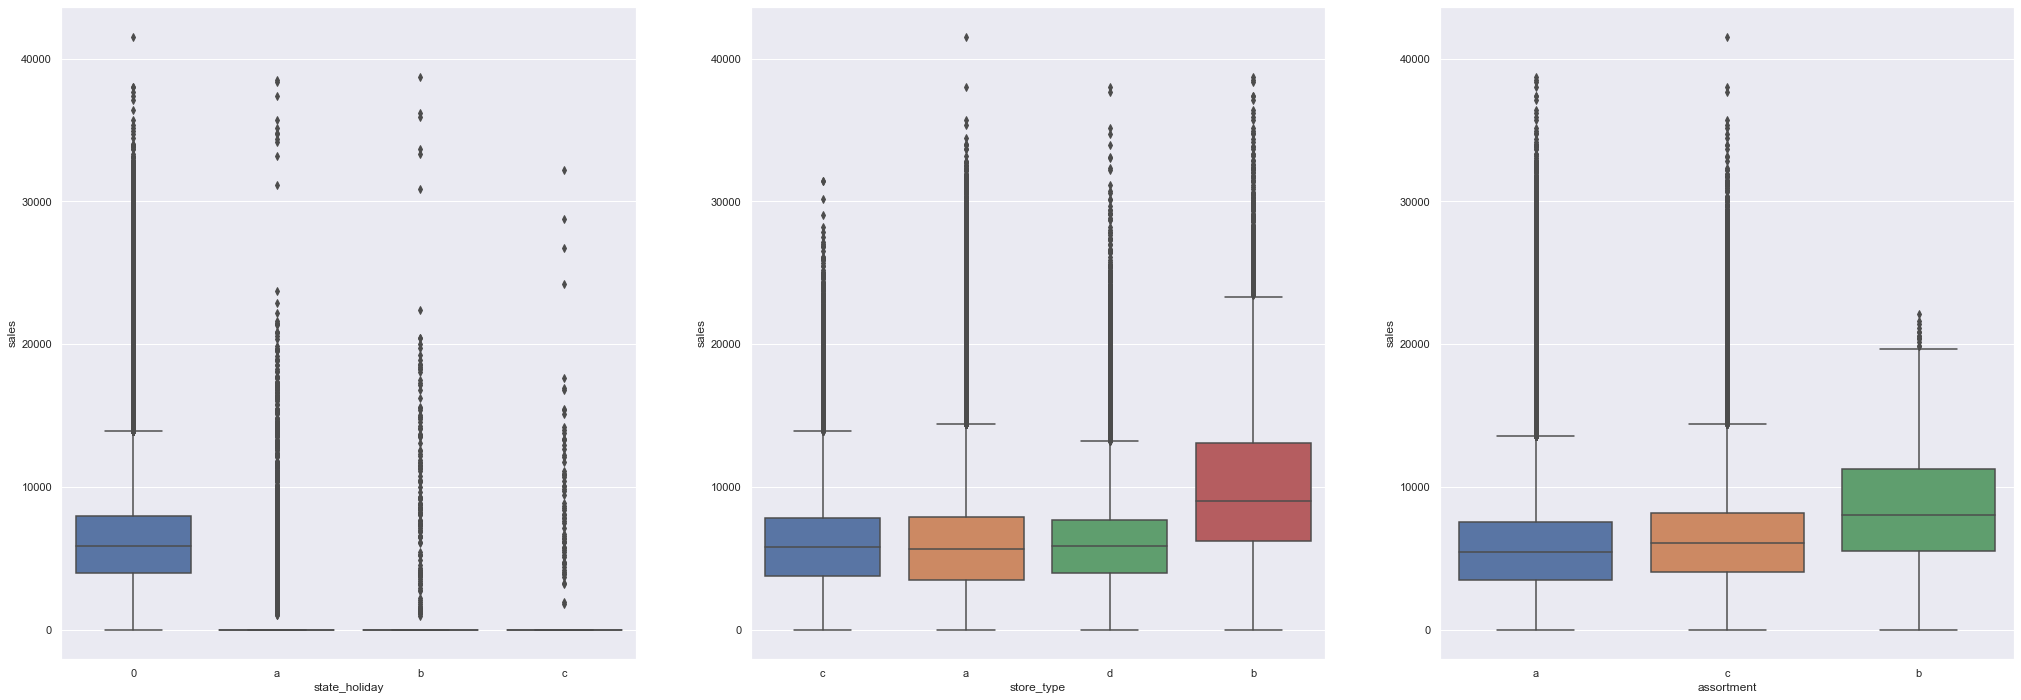

In [38]:
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=df1 );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=df1 );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=df1 );

## 1.8 Resumo

In [39]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}\n'.format( df1.shape[1] ) )
print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )
print( 'Num of Categorical: {}'.format( cat_attributes.shape[1] ) )
print( 'Num of Date: {}\n'.format( dat_attributes.shape[1] ) )



Number of Rows: 1017209
Number of Cols: 20

Num of Numerical: 10
Num of Categorical: 9
Num of Date: 1



# 2.0. Feature Engineering - Passo 02

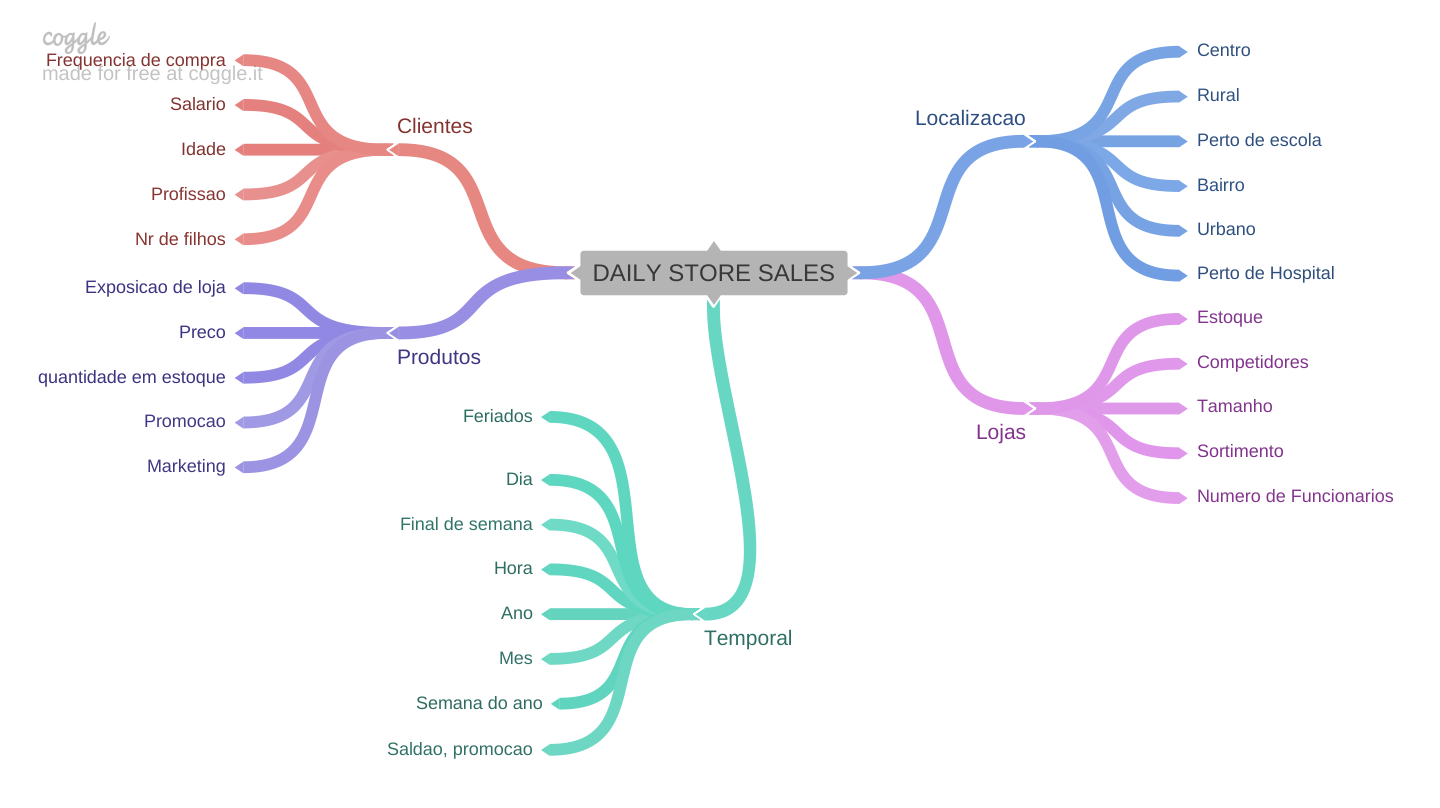

In [153]:
Image('img/MindMapHipothesis.png')

## 2.1. Criacao das Hipoteses

In [40]:
df2 = df1.copy()

### 2.1.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoer mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem precos menores nos produtos deveriam vender mais.

**4.** Lojas que tem precos menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas que tem uma quantidade de estoque maior deveriam vender mais

### 2.1.3. Hipoteses Tempo

**1.** Lojas que tem mais feriados elas deveriam vender menos.

**2.** Lojas que abrem nos primeiro 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semanas deveriam vender mais.

**4.** Lojas que saldao mais frequentes deveriam vender mais.

**5.** Lojas que ficam abertas por maior periodo de horas deveriam vender mais.

## 2.2 Lista final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com maior porte deveriam vender mais.

**3.** Lojas com menor porte deveriam vender menos.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais promocoes consecutivas deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

**13.** Lojas com competidores mais proximos deveriam vende menos.

## 2.3. Feature Engineering

In [41]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# competition
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int ) 

# promotion
df2['promotion_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promotion_since'] = df2['promotion_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promotion_time_week'] = ( ( df2['date'] - df2['promotion_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

In [42]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Filtragem de variaveis - Passo 03

In [43]:
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [44]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.1. Selecao das linhas

In [45]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis = 1 )

In [46]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promotion_since', 'promotion_time_week'],
      dtype='object')

In [47]:
df4 = df3.copy()

# 4.0 Analise Exploratoria de dados - Passo 04

## 4.1 Analise univariada

### 4.1.1. Response Variable

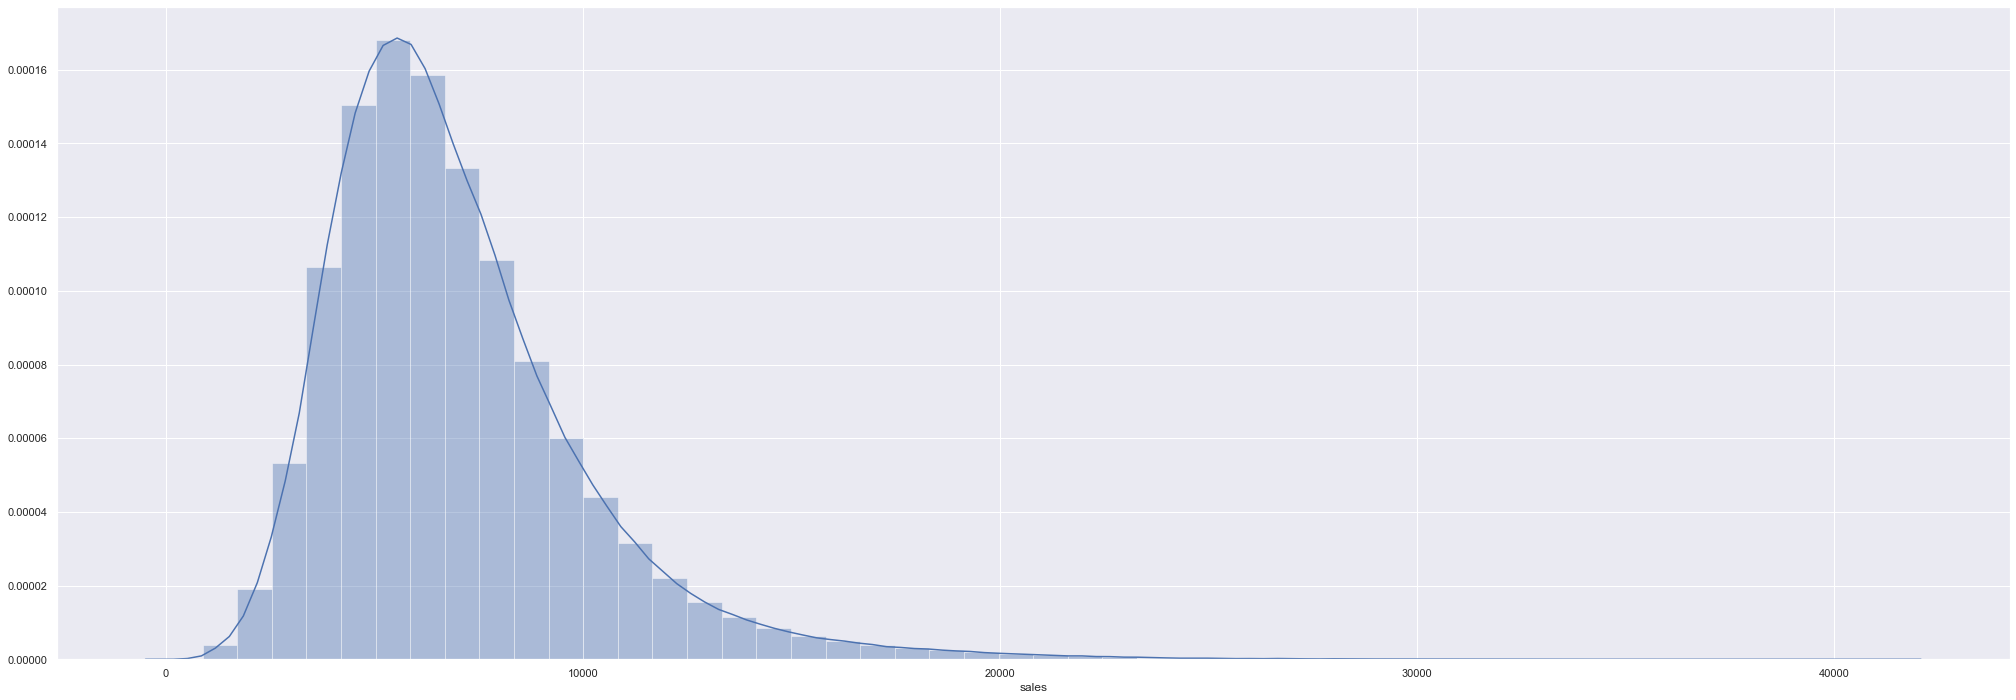

In [48]:
sns.distplot(df4['sales'])

### 4.1.2. Numercial Variable

In [ ]:
num_attributes.hist( bins=25 );

### 4.1.3. Categorical Variable

In [49]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [ ]:
#state_holiday
plt.subplot( 3, 2, 1);
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday']);

plt.subplot( 3, 2, 2 );
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True );

#store_type
plt.subplot( 3, 2, 3);
sns.countplot( df4['store_type'] );

plt.subplot( 3, 2, 4 );
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True );

#assortment
plt.subplot( 3, 2, 5);
sns.countplot( df4['assortment'] );

plt.subplot( 3, 2, 6 );
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True );
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True );
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True );




## 4.2 Analise Bivariada

### H1.Lojas com maior sortimentos deveriam vender mais
**Falsa** lojas com maior sortimento vendem menos.

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### H2. Lojas com competidores mais proximos deveriam vender menos
**Falsa** Lojas com competidores mais proximos vendem mais.

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list( np.arange(0,20000,1000))

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

In [ ]:
aux1.sample(4)

### H3. Lojas com competidores a mais tempo deveriam vender mais
**Falsa** Lojas com competidores a mais tempo vendem menos

In [ ]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales',data=aux2 );
plt.xticks( rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales',data=aux2 );

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);



### H4. Lojas com promocoes ativas por mais tempo deveriam vender mais.
**Falsa** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

In [ ]:
aux1 = df4[['promotion_time_week', 'sales']].groupby('promotion_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promotion_time_week'] > 0] # promo extended
sns.barplot(x='promotion_time_week', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promotion_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promotion_time_week'] < 0] # promo regular
sns.barplot(x='promotion_time_week', y='sales', data=aux3);
plt.xticks( rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promotion_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr('pearson'), annot=True);



### H5. Lojas com mais promocoes consecutivas deveriam vender mais. ON HOLD PARA PROXIMO CICLO DO CRISP



### H6. Lojas com mais promocoes consecutivas deveriam vender mais.
**Falsa** Lojas com mais promocoes consecutivas vendem menos

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Estendida', ' Estendida']);

### H8. Lojas abertas durante o feriado de natal deveriam vender mais
**Falsa** Lojas abertas durante o natal vendem menos

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);

### H9. Lojas deveriam vender mais no segundo semestre do ano
**Falsa** lojas vendem menpos aos longos doa anos

In [ ]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais no segundo semestre do ano.
**Falsa** Lojas vendem menos no segundo semestre do ano

In [ ]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H11. Lojas deveriam vender mais depois do dia 10 de cada mes.
**True**  

In [ ]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10-days' if x<= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data = aux2);

### H12. Lojas deveriam menos aos finais de semana.
**True** Lojas vendem menos aos finais de semana

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H13. Lojas com competidores mais proximos deveriam vende menos.
**True**

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);


aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

# plt.subplot(1,3,3)
# sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [ ]:
from tabulate import tabulate

In [ ]:
tab = [['Hipotese', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Media'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa'],      
      ]
print(tabulate(tab, headers='firstrow'))

## 4.3 Analise Multivariada

### 4.3.1 Numerical Atributes

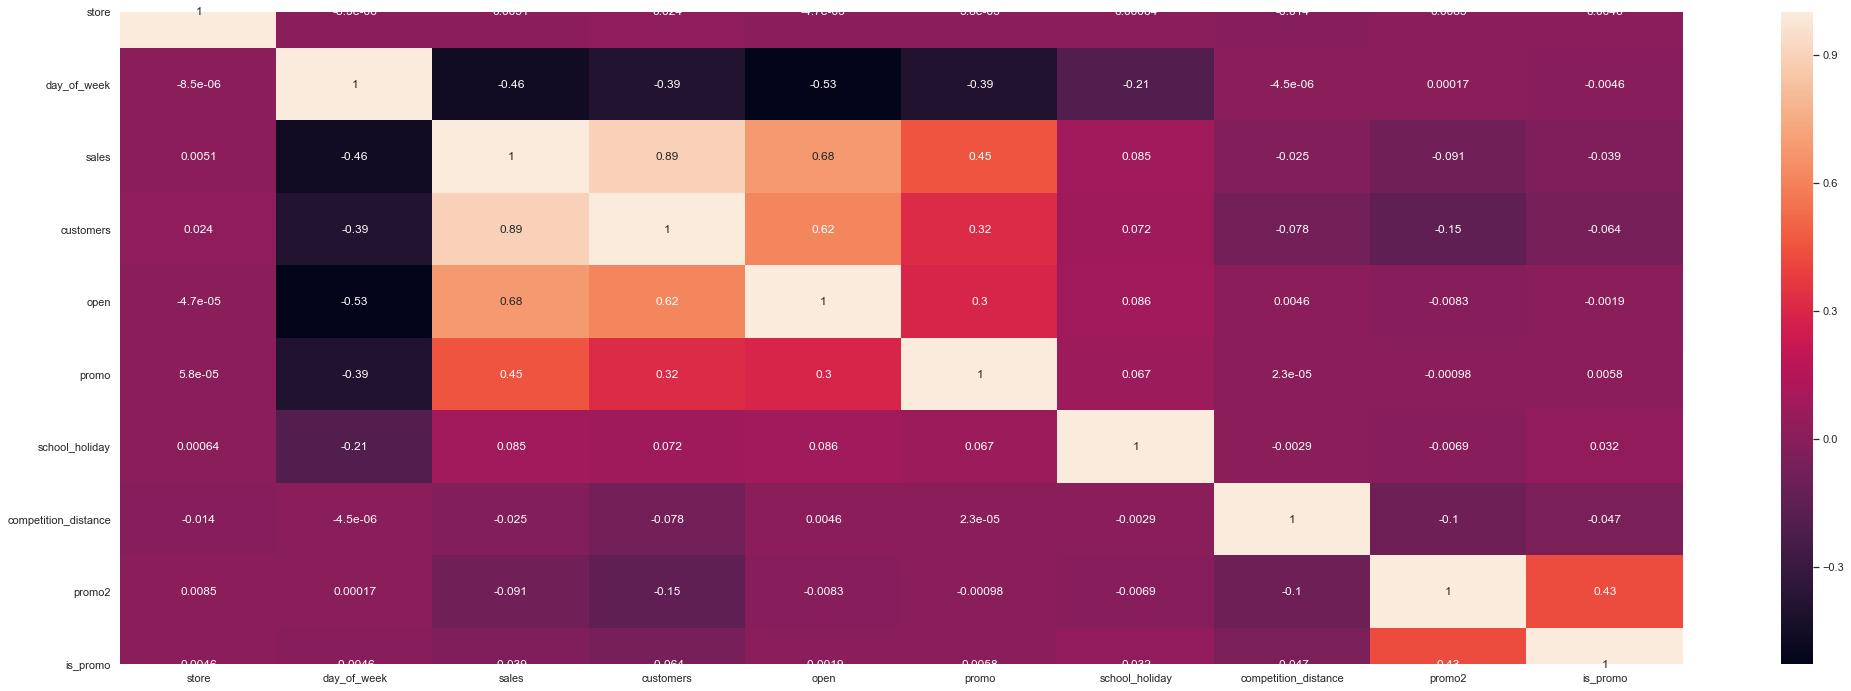

In [50]:
correlation = num_attributes.corr( method = 'pearson')
sns.heatmap( correlation, annot=True);

### 4.3.2. Categorical Attributes

In [ ]:
#categorical data
a = df4.select_dtypes(include='object')

#calculate cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#final dataset
d = pd.DataFrame({'state_holiday':[a1,a2,a3], 
                  'store_type':   [a4,a5,a6],
                  'assortment':   [a7,a8,a9] })

d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 5.0. Data Preparation -  Passo 05

In [51]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling

In [52]:
a = df5.select_dtypes(include=['int64', 'float64'])

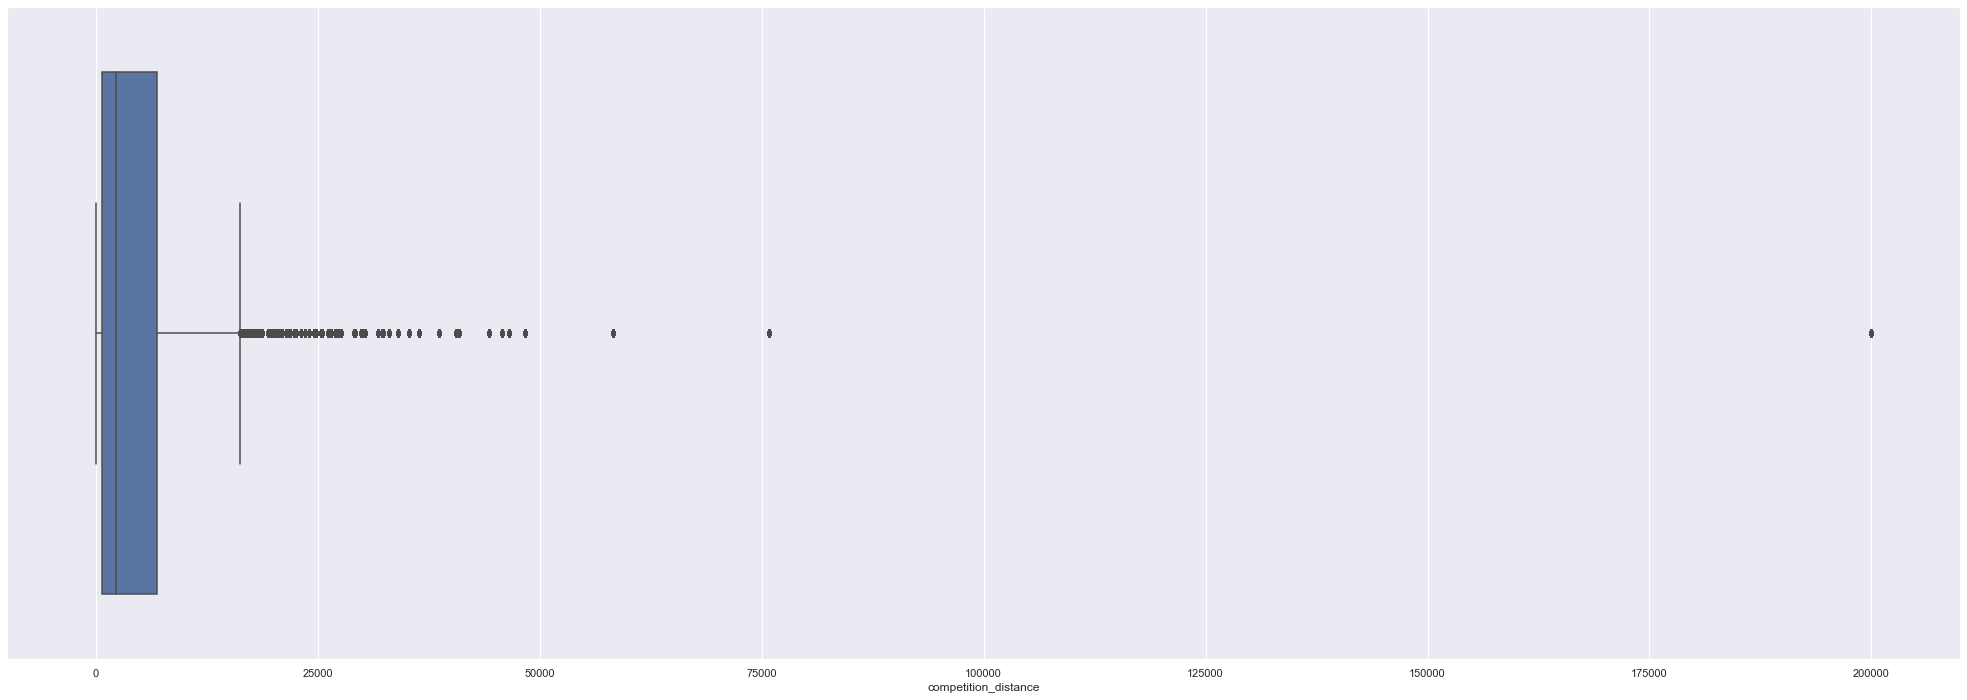

In [53]:
sns.boxplot( df5['competition_distance']);

In [54]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance - 
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values) 

#competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values) 

#promotion_time_week
df5['promotion_time_week'] = mms.fit_transform( df5[['promotion_time_week']].values) 

#year - linear growth , not come back in time
df5['year'] = mms.fit_transform( df5[['year']].values) 

C:\Users\Cidones\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Cidones\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## 5.3. Transformation

### 5.3.1. Encoding

In [55]:
#state_holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )


In [56]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promotion_since,promotion_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Response Variable Transformation

In [57]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [58]:
#month- sin and cos natural
df5['month_sin'] = df5['month'].apply(lambda x: sin(x*(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: cos(x*(2. * np.pi/12)))

#day- natureza ciclica
df5['day_sin'] = df5['day'].apply(lambda x: sin(x*(2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: cos(x*(2. * np.pi/30)))

#week_of_year- natureza ciclica
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: sin(x*(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: cos(x*(2. * np.pi/52)))

#day_of_week- natureza ciclica
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: sin(x*(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: cos(x*(2. * np.pi/7)))

In [59]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promotion_since,promotion_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0. FEATURE SELECTION - Passo 06

In [60]:
df6 = df5.copy()

In [61]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promotion_since,promotion_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


## 6.1. Split Dataframe into training and dataset

In [62]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promotion_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1) # axis = 1 along line to delete whole column

In [63]:
df6[['store', 'date']].groupby( 'store').max().reset_index()['date'][0] - datetime.timedelta(days =7*6)

Timestamp('2015-06-19 00:00:00')

In [64]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min Date:{}'.format(X_train['date'].min() ) )
print('Training max Date:{}'.format(X_train['date'].max() ) )

print('\nTest min Date:{}'.format(X_test['date'].min() ) )
print('Test max Date:{}'.format(X_test['date'].max() ) )

Training min Date:2013-01-01 00:00:00
Training max Date:2015-06-18 00:00:00

Test min Date:2015-06-19 00:00:00
Test max Date:2015-07-31 00:00:00


## 6.2. Boruta Feature Selector

In [65]:
#Training and test dataset for boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# #define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1)

# #Define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1 Best features from boruta

In [66]:
cols_selected = boruta.support_.tolist()

#Best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#Not_selected boruta
cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

NameError: name 'boruta' is not defined

In [67]:
cols_selected_boruta

NameError: name 'cols_selected_boruta' is not defined

In [ ]:
cols_not_selected_boruta

## 6.3. Best features from boruta

In [68]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promotion_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

#columns to add
feat_to_add = ['date', 'sales']

#final features
#cols_selected_boruta.extend( feat_to_add )

In [69]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promotion_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0. Machine Learning Modelling - Passo 07

## 7.1. Average Model 

In [70]:
#only relevant columns
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [71]:
#original dataset but only test
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#Performance
baseline_result = ml_error( 'Average Model ', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [72]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict( x_test )

#performance
lr_result = ml_error('Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr))
lr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression,1868.313299,0.292392,2674.576594


## 7.3. Linear Regression Regularized Model - Lasso

In [73]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict( x_test )

#performance
lrr_result = ml_error('Linear Regression Lasso', np.expm1( y_test ), np.expm1(yhat_lrr))
lrr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1891.70488,0.289106,2744.451735


## 7.4. Random Forest Regressor

In [86]:
#model
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict( x_test )

#performance
rf_result = ml_error('Random Forest Regression', np.expm1( y_test ), np.expm1(yhat_rf))
rf_result

,Model name,MAE,MAPE,RMSE
0,Random Forest Regression,702.792852,0.104293,1040.836056


## 7.5. XGBoost Regressor 

In [84]:
import xgboost as xgb

In [85]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100, 
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytee=0.9,
                            n_jobs=-1,
                            random_state=42).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict( x_test )

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb))
xgb_result

C:\Users\Cidones\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Cidones\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,845.802403,0.123775,1242.82294


## 7.6.Compare Model's Performance

In [89]:
modelling_result = pd.concat([ baseline_result, lr_result, lrr_result, rf_result, xgb_result ])
modelling_result.sort_values( 'RMSE' )

,Model name,MAE,MAPE,RMSE
0,Random Forest Regression,702.792852,0.104293,1040.836056
0,XGBoost Regressor,845.802403,0.123775,1242.822940
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1868.313299,0.292392,2674.576594
0,Linear Regression Lasso,1891.704880,0.289106,2744.451735
